adapted from Gao et al. 2010 (http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5545418)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
from astropy.table import Column
from astropy.table import Table
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from itertools import product
from scipy.spatial import distance_matrix
%matplotlib inline

# preparing input data

In [2]:
# loading training labels
f = open('/Users/eilers/Dropbox/cygnet/data/training_labels_apogee_tgas.pickle', 'r')
training_labels = pickle.load(f)
f.close()

# loading normalized spectra
f = open('/Users/eilers/Dropbox/cygnet/data/apogee_spectra_norm.pickle', 'r')    
spectra = pickle.load(f)
f.close()

wl = spectra[:, 0, 0]
fluxes = spectra[:, :, 1].T
ivars = (1./(spectra[:, :, 2]**2)).T 

In [3]:
# remove duplicates       
foo, idx = np.unique(training_labels['APOGEE_ID'], return_index = True)
training_labels = training_labels[idx]
fluxes = fluxes[idx, :]
ivars = ivars[idx, :]
        
# data masking       
masking = training_labels['K'] < 0.
training_labels = training_labels[~masking]
fluxes = fluxes[~masking]
ivars = ivars[~masking]

# scaling of data and training labels?!

In [4]:
# calculate K_MAG_ABS and Q

Q = 10**(0.2*training_labels['K']) * training_labels['parallax']/100.                    # assumes parallaxes is in mas
Q_err = training_labels['parallax_error'] * 10**(0.2*training_labels['K'])/100. 
Q = Column(Q, name = 'Q_MAG')
Q_err = Column(Q_err, name = 'Q_MAG_ERR')
training_labels.add_column(Q, index = 12)
training_labels.add_column(Q_err, index = 13)

In [5]:
# latex

latex = {}
latex["TEFF"] = r"$T_{\rm eff}$"
latex["LOGG"] = r"$\log g$"
latex["FE_H"] = r"$\rm [Fe/H]$"
latex["ALPHA_M"] = r"$[\alpha/\rm M]$"
latex["C_FE"] = r"$\rm [C/Fe]$"
latex["N_FE"] = r"$\rm [N/Fe]$"
latex["Q_MAG"] = r"$Q$"

In [6]:
def make_label_input(labels, training_labels):
    tr_label_input = np.array([training_labels[x] for x in labels]).T
    tr_ivar_input = 1./((np.array([training_labels[x+'_ERR'] for x in labels]).T)**2)
    for x in range(tr_label_input.shape[1]):
        bad = np.logical_or(tr_label_input[:, x] < -100., tr_label_input[:, x] > 9000.) # magic
        tr_label_input[bad, x] = np.median(tr_label_input[:, x])
        tr_ivar_input[bad, x] = 0.
    # remove one outlier in T_eff and [N/Fe]!
    bad = tr_label_input[:, 0] > 5200.
    tr_label_input[bad, 0] = np.median(tr_label_input[:, 0])
    tr_ivar_input[bad, 0] = 0.  
    #bad = tr_label_input[:, 5] < -0.6
    #tr_label_input[bad, 5] = np.median(tr_label_input[:, 5])
    #tr_ivar_input[bad, 5] = 0.     
    return tr_label_input, tr_ivar_input

In [7]:
labels = np.array(['TEFF', 'FE_H', 'LOGG']) #, 'ALPHA_M', 'Q_MAG', 'N_FE', 'C_FE'])
Nlabels = len(labels)
latex_labels = [latex[l] for l in labels]
tr_label_input, tr_ivar_input = make_label_input(labels, training_labels)
print(Nlabels, tr_label_input.shape, tr_ivar_input.shape, fluxes.shape, ivars.shape)

(3, (2180, 3), (2180, 3), (2180, 8575), (2180, 8575))


In [8]:
# scale and pivot labels
def get_pivots_and_scales(label_vals):  
    qs = np.percentile(label_vals, (2.5, 50, 97.5), axis=0)
    pivots = qs[1]
    scales = (qs[2] - qs[0])/4.    
    return pivots, scales

pivots, scales = get_pivots_and_scales(tr_label_input)
tr_label_input_scaled = (tr_label_input - pivots) / scales
print('pivots: {}'.format(pivots))
print('scales: {}'.format(scales))

pivots: [  4.22088330e+03  -2.17777684e-01   1.61374539e+00]
scales: [ 200.23879089    0.48587545    0.33995598]


In [9]:
# take subset of data as input data
X = fluxes[:2, 500:600]
Y = tr_label_input_scaled[:2, :]
print X.shape, Y.shape 
N = X.shape[0]
D = X.shape[1]
L = Y.shape[1]
assert Y.shape[0] == N

(2, 100) (2, 3)


# Supervised GPLVM

X: input spectra -- N x D

Y: input labels -- N x L

Z: latent space -- N x Q with Q>=L

In [142]:
def logLikelihood_Z(pars, X, Y, hyper_params):
    
    print pars
    Z = np.reshape(pars, (Y.shape[0], Y.shape[1]))  
    theta_rbf, theta_band, gamma_rbf, gamma_band = hyper_params    
    kernel1 = kernelRBF(Z, theta_rbf, theta_band)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band)
    print kernel1, kernel2
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_Z: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20)     
    print np.linalg.norm(Z)
    
    gradL = dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band)    
    # reshape gradL back into 1D array
    gradL = np.reshape(gradL, (Y.shape[0] * Y.shape[1], ))
    print -2.*Lx, -2.*Ly 
    return -2.*L, -2.*gradL
                    
def logLikelihood_hyper(pars, X, Y, Z):
    
    print pars
    Z = np.reshape(Z, (Y.shape[0], Y.shape[1]))      
    theta_rbf, theta_band, gamma_rbf, gamma_band = pars    
    kernel1 = kernelRBF(Z, theta_rbf, theta_band)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band)
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_h: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20) 
    
    gradL = dLdhyper(X, Y, Z, pars) 
    print -2.*Lx, -2.*Ly 
    return -2.*L, -2.*gradL


# eq. (21), (22)
def dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band):   
    dlnpdZ = Z / np.linalg.norm(Z)
    gradL = np.dot(dLdK(kernel1, X), dKdZ(theta_rbf, theta_band, Z)) + np.dot(dLdK(kernel2, Y), dKdZ(gamma_rbf, gamma_band, Z)) + dlnpdZ  
    return 0.5 * gradL


def A_matrix(Z):                                 # should be shape: (N x N) x (N x Q)...
    N, Q = Z.shape[0], Z.shape[1]
    A = np.zeros((N, N, N, Q))
    for entry in list(product(range(N), repeat=3)):
        i, j, l = entry
        if l == j:
            A[i, j, l, :] += Z[i, :] - Z[l, :]
        if l == i:
            A[i, j, l, :] += Z[j, :] - Z[l, :]
    return A


def B_matrix(Z):
    N = Z.shape[0]
    B = np.zeros((N, N))
    for entry in list(product(range(N), repeat=2)):
        i, j = entry
        B[i, j] = -0.5 * np.dot((Z[i, :] - Z[j, :]).T, (Z[i, :] - Z[j, :]))
    return B


# eq. (25), (26)
def dKdZ(rbf, band, Z):
    #B = B_matrix(Z)
    #kernel_short = rbf * np.exp(band * B)
    kernel = kernelRBF(Z, rbf, band)
    A = A_matrix(Z)
    grad_dKdZ = band * np.tensordot(kernel, A)
    #grad_dKdZ = band * np.dot(kernel, A)
    # same as:
    #grad_dKdZ = np.zeros_like(Z)
    #for i in range(Z.shape[0]):
    #    for j in range(Z.shape[0]):
    #        grad_dKdZ += kernel1[i, j] * A[i, j, :, :]
    return grad_dKdZ                     


# eq. (23), (24)
def dLdK(K, data):   
    inv_K = np.linalg.inv(K)
    #grad_dLdK = 0.5 * (np.dot(inv_K, np.dot(data, np.dot(data.T, inv_K))) - data.shape[1] * inv_K)
    grad_dLdK = 0.5 * ((inv_K * np.dot(data, data.T) * inv_K) - data.shape[1] * inv_K)
    return grad_dLdK                     # shape: N x N 


# eq. (28)
def dLdhyper(X, Y, Z, hyper_params):  

    theta_rbf, theta_band, gamma_rbf, gamma_band = hyper_params 
    #B = B_matrix(Z)
    #kernel_short = theta_rbf * np.exp(theta_band * B)
    kernel1 = kernelRBF(Z, theta_rbf, theta_band)
    
    dKdrbf, dKdband = dKdhyper(Z, kernel1, theta_rbf, theta_band) 
    dLdtheta_rbf = np.sum(dLdK(kernel1, X) * dKdrbf)
    dLdtheta_band = np.sum(dLdK(kernel1, X) * dKdband)
    #dLdsigmax2 = np.sum(dLdK(kernel_short, X) * dKdsigma2)
    
    #kernel_short = theta_rbf * np.exp(theta_band * B)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band)
    dKdrbf, dKdband = dKdhyper(Z, kernel2, gamma_rbf, gamma_band)  
    dLdgamma_rbf = np.sum(dLdK(kernel2, Y) * dKdrbf)
    dLdgamma_band = np.sum(dLdK(kernel2, Y) * dKdband)
    #dLdsigmay2 = np.sum(dLdK(kernel_short, Y) * dKdsigma2)
    return np.array([dLdtheta_rbf, dLdtheta_band, dLdgamma_rbf, dLdgamma_band])


# eq. (29), (30)
def dKdhyper(Z, K, rbf, band):
    dKdrbf = 1./rbf * K
    B = B_matrix(Z)
    dKdband = K * B
    #dKdsigma2 = np.eye(Z.shape[0])
    return dKdrbf, dKdband


# eq. (18), (19)
def LxOrLy(K, data):   
    L_term1 = -0.5 * data.shape[0] * data.shape[1] * np.log(2.*np.pi)
    L_term2 = -0.5 * data.shape[1] * np.linalg.slogdet(K)[1]
    #L_term3 = -0.5 * np.matrix.trace(np.dot(np.linalg.inv(K), np.dot(data, data.T)))
    L_term3 = -0.5 * np.matrix.trace(np.linalg.inv(K) * np.dot(data, data.T))
    return L_term1 + L_term2 + L_term3


# radius basis function
def kernelRBF(Z, rbf, band):   
    B = B_matrix(Z)
    kernel = rbf * np.exp(band * B) # + sigma2 * np.eye(Z.shape[0])
    return kernel

def PCAInitial(X, Q):
    pca = PCA(Q)
    Z_initial = pca.fit_transform(X)
    return Z_initial

In [150]:
def test_likelihood_h(pars, X, Y, Z):
    
    q, dldq = logLikelihood_hyper(pars, X, Y, Z)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-3 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_hyper(pars1, X, Y, Z)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

def test_likelihood_Z(pars, X, Y, hyper_params):
    
    q, dldq = logLikelihood_Z(pars, X, Y, hyper_params)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-2 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_Z(pars1, X, Y, hyper_params)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

In [39]:
# initialization 
theta_rbf, theta_band, gamma_rbf, gamma_band = 1.37, 1.1415, 1.37, 1.1415 
hyper_params = np.array([theta_rbf, theta_band, gamma_rbf, gamma_band])

Q = Y.shape[1]
Z_initial = Y[:] #PCAInitial(X, Q)
Z = Z_initial[:]
Z = np.reshape(Z, (N*Q, ))
print Z.shape, Z

(6,) [ 2.07809502 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]


(2, 2)


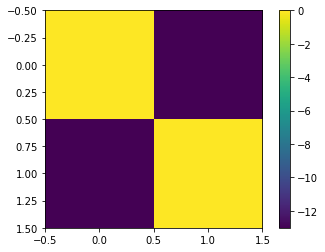

In [32]:
kernel1 = kernelRBF(Z_initial, theta_rbf, theta_band)
kernel2 = kernelRBF(Z_initial, theta_rbf, theta_band)
print kernel1.shape
#B = -0.5 * cdist(Z_initial, Z_initial).T * cdist(Z_initial, Z_initial) 
B = B_matrix(Z_initial)
plt.imshow(B, interpolation='None')
plt.colorbar()

In [33]:
grad_dLdK = dLdK(kernel1, X)
dKdrbf, dKdband = dKdhyper(Z_initial, kernel1, theta_rbf, theta_band)
L, gradL = logLikelihood_hyper(hyper_params, X, Y, Z)
print L, gradL
hyper_new = hyper_params[:] 
hyper_new = (1. + 1e-7) * hyper_params
# print hyper_new
L, gradL = logLikelihood_hyper(hyper_new, X, Y, Z)
print L, gradL 

A = A_matrix(Z_initial)
print A.shape
print np.dot(kernel1, A).shape

[ 1.37    1.1415  1.37    1.1415]
568.863312174 28.9603905891
593.135351249 [  4.50177001e+01   6.28381797e-04  -7.33157938e+00  -1.35177569e-05]
[ 1.37000014  1.14150011  1.37000014  1.14150011]
568.863318342 28.9603895847
593.135356412 [  4.50177057e+01   6.28380800e-04  -7.33157748e+00  -1.35177355e-05]
(2, 2, 2, 3)
(2, 2, 2, 3)


In [99]:
from scipy.spatial import distance_matrix
#B2 = mat(Z, Z)
B = B_matrix(Z_initial)
print B, mat(Z_initial, Z_initial)
xx = np.sqrt((2.07809502+1.79058551)**2 + (-3.01397246+0.59766333)**2 + (0.05060757+2.23878806)**2)
B2 = -0.5 * mat(Z_initial, Z_initial)**2
print xx, B2
print (Z_initial[0, :] - Z_initial[1, :]).shape
print np.dot((Z_initial[0, :] - Z_initial[1, :]).T, (Z_initial[0, :] - Z_initial[1, :]))

[[ -0.        -13.0232856]
 [-13.0232856  -0.       ]] [[ 0.          5.10358415]
 [ 5.10358415  0.        ]]
5.10358415289 [[ -0.        -13.0232856]
 [-13.0232856  -0.       ]]
(3,)
26.0465712052


In [151]:
# testing likelihood functions
theta_rbf, theta_band, gamma_rbf, gamma_band = 1.37, 1.1415, 1.37, 1.1415 
hyper_params = np.array([theta_rbf, theta_band, gamma_rbf, gamma_band])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q, ))

#test_likelihood_h(hyper_params, X, Y, Z)
test_likelihood_Z(Z, X, Y, hyper_params)

[ 2.07809502 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]
[[  1.37000000e+00   4.79141548e-07]
 [  4.79141548e-07   1.37000000e+00]] [[  1.37000000e+00   4.79141548e-07]
 [  4.79141548e-07   1.37000000e+00]]
4.68835151388
568.863360425 28.9603895512
[ 2.09887597 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]
[[  1.37000000e+00   4.37019954e-07]
 [  4.37019954e-07   1.37000000e+00]] [[  1.37000000e+00   4.37019954e-07]
 [  4.37019954e-07   1.37000000e+00]]
4.69759952997
568.863360425 28.9603895512
(0, 593.13539846198307, 593.12615044589768, -0.44502373528448302, -0.44327942480676413, -0.0019636432201138566)
[ 2.07809502 -3.04411218  0.05060757 -1.79058551 -0.59766333 -2.23878806]
[[  1.37000000e+00   4.40691769e-07]
 [  4.40691769e-07   1.37000000e+00]] [[  1.37000000e+00   4.40691769e-07]
 [  4.40691769e-07   1.37000000e+00]]
4.70778386507
568.863360425 28.9603895512
(1, 593.13539846198307, 593.1159661107921, 0.64474216217058677, 0.64288462532162294, -0.00

In [132]:
# iterative algorithm (Table 1)
#theta_rbf, theta_band, gamma_rbf, gamma_band = 1.3, 1.1415, 1.37, 1.5415
#hyper_params = np.array([theta_rbf, theta_band, gamma_rbf, gamma_band])
# result of first optimization
hyper_params = np.array([0.9405172, 0.00633514, 3.81331846, 1.54153404])
Z_initial = Y[:] #PCAInitial(X, Q)
Z = np.reshape(Z_initial, (N*Q, ))

print('theta_start: %s' %hyper_params)
print('Z_start: %s' %Z)

max_iter = 1
for t in range(max_iter):
    
    # optimize hyperparameters
#    print("optimizing hyper parameters")
#    res = op.minimize(logLikelihood_hyper, x0 = hyper_params, args = (X, Y, Z, Z_initial), method = 'L-BFGS-B', jac = True, 
#                      options={'gtol':1e-12, 'ftol':1e-12})
    
    # update hyperparameters
#    hyper_params = res.x
#    print hyper_params
#    print res
             
    # optimize Z
    print("optimizing latent parameters")
    res = op.minimize(logLikelihood_Z, x0 = Z, args = (X, Y, hyper_params, Z_initial), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
             
    # update Z
    Z = res.x
    print Z
    print res
    
    # check convergence
 
Z_final = np.reshape(Z, (N, Q))

theta_start: [ 0.9405172   0.00633514  3.81331846  1.54153404]
Z_start: [ 2.07809502 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]
optimizing latent parameters
[ 2.07809502 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]
[[ 0.9405172   0.86603524]
 [ 0.86603524  0.9405172 ]] [[  3.81331846e+00   7.28580231e-09]
 [  7.28580231e-09   3.81331846e+00]]
4.68835151388
1491.61002727 24.8224374869
[ 2.45090124 -3.25635535  0.26467391 -2.45101055 -0.19470833 -2.63616407]
[[ 0.9405172   0.82383541]
 [ 0.82383541  0.9405172 ]] [[  3.81331846e+00   3.83170061e-14]
 [  3.83170061e-14   3.81331846e+00]]
5.44752645016
1075.29232376 24.8224374869
[ 4.20688954 -4.39951627  1.27194241 -4.17488603  0.83559184 -3.68819844]
[[ 0.9405172   0.63851917]
 [ 0.63851917  0.9405172 ]] [[  3.81331846e+00   4.51679518e-41]
 [  4.51679518e-41   3.81331846e+00]]
8.39060161133
667.284641639 24.8224374869
[ 5.98754402 -5.57643753  2.28119574 -5.53367292  1.61950989 -4.53679386]
[[ 0.9405172 

In [1653]:
print res

      fun: -516134864084193.5
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.87529272e+08,  -1.17127451e+08,   1.10975484e+08,
        -1.98518919e+08,   1.23991391e+08,  -1.17478903e+08])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 44
      nit: 16
   status: 2
  success: False
        x: array([  5.66005477e+13,  -3.17379653e+14,  -1.73153476e+14,
         5.17539806e+13,  -3.14352573e+14,  -1.76021562e+14])


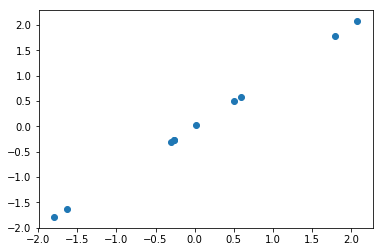

In [665]:
plt.scatter(Z_initial[:, 0], Z_final[:, 0])

# testing stuff...

In [1046]:
N, Q, D = 2, 2, 10
X = np.ones((N, D))
Y = np.ones((N, Q))
Y[0, 0] = 2. 
Y[0, 1] = -1.
Y[1, 0] = -2.
print Y
Z_initial = Y[:]
Z = Z_initial[:]
#Z = np.reshape(Z, (N*Q, ))
print Z.shape

[[ 2. -1.]
 [-2.  1.]]
(2, 2)


In [1047]:
theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = 1, 1, 1, 1, 1, 1
hyper_params = np.array([theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2])

In [1048]:
# test kernel!

kernel1 = kernelRBF(Z_initial, theta_rbf, theta_band, sigmax2)
print kernel1

# manual test
K = np.zeros((N, N))
for i in range(2):
    for j in range(2):
        K[i, j] = theta_rbf * np.exp(-0.5 * theta_band * ( (Z[i, 0] - Z[j, 0])**2 +  (Z[i, 1] - Z[j, 1])**2)) 
print K + sigmax2*np.eye(N)

[[  2.00000000e+00   4.53999298e-05]
 [  4.53999298e-05   2.00000000e+00]]
[[  2.00000000e+00   4.53999298e-05]
 [  4.53999298e-05   2.00000000e+00]]


In [1049]:
# test Lx and Ly

Lx = LxOrLy(kernel1, Y)

det = kernel1[0, 0] * kernel1[1, 1] - kernel1[0, 1] * kernel1[1, 0]
print det, np.linalg.det(kernel1)

inv_mat = np.zeros((N, N))
inv_mat[0, 0] = 1./det * kernel1[1, 1]
inv_mat[1, 0] = -1./det * kernel1[0, 1]
inv_mat[0, 1] = -1./det * kernel1[1, 0]
inv_mat[1, 1] = -1./det * kernel1[0, 0]
#print inv_mat, np.linalg.inv(kernel1)

Lx_man = - 0.5 * Q * N * np.log(2*np.pi)
Lx_man += - 0.5 * Q * np.log(np.linalg.det(kernel1))
brackets = np.dot( np.linalg.inv(kernel1), np.dot(Y, Y.T))
Lx_man += - 0.5 * np.matrix.trace(brackets)
print Lx, Lx_man

3.99999999794 3.99999999794
-7.56210524462 -7.56210524462


In [1050]:
# test dKdhyper

dKdrbf, dKdband, dKdsigma2 = dKdhyper(Z, kernel1, theta_rbf, theta_band, sigmax2)

drbf = 1/theta_rbf * kernel1
print dKdrbf - drbf
print dKdsigma2 - np.eye(2)
B = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        B[i, j] = -0.5 * ( (Z[i, 0] - Z[j, 0])**2 + (Z[i, 1] - Z[j, 1])**2)
print dKdband - np.dot(kernel1, B)

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]


In [1051]:
# test dLdK
K = kernel1
grad_dLdK = dLdK(K, Y)
#print grad_dLdK

term1 = np.zeros((2, 2))
term1[0, 0] = 5 * (K[1, 1] + K[1, 0]) * (K[1, 1] + K[0, 1])
term1[0, 1] = 5 * (K[0, 1] + K[0, 0]) * (-K[1, 1] - K[0, 1])
term1[1, 0] = 5 * (K[1, 1] + K[1, 0]) * (-K[1, 0] - K[0, 0]) 
term1[1, 1] = 5 * (K[0, 0] + K[0, 1]) * (K[0, 0] + K[1, 0]) 

term2 = Q * np.linalg.inv(K)
#print term1/(det**2) + term2

#xx = np.dot(np.linalg.inv(K), np.dot(Y, np.dot(Y.T, np.linalg.inv(K))))
#print xx - term2
print term1/(det**2) - term2
print grad_dLdK

[[ 0.25005675 -1.25003405]
 [-1.25003405  0.25005675]]
[[ 0.25005675 -1.25003405]
 [-1.25003405  0.25005675]]


In [1052]:
# test dLdhyper

xx = np.tensordot(grad_dLdK, dKdrbf)
print xx
bla = 1./ theta_rbf * (grad_dLdK[0, 0]*dKdrbf[0, 0] + grad_dLdK[1, 0]*dKdrbf[1, 0] + grad_dLdK[0, 1]*dKdrbf[0, 1] + grad_dLdK[1, 1]*dKdrbf[1, 1])
print bla

xx = np.tensordot(grad_dLdK, dKdsigma2)
print xx
bla = grad_dLdK[0, 0]*dKdsigma2[0, 0] + grad_dLdK[1, 1]*dKdsigma2[1, 1]
print bla

xx = np.tensordot(grad_dLdK, dKdband)
print xx
KB = np.zeros((2, 2))
KB[0,0] = K[0,0]*B[0,0] + K[0,1]*B[1,0]
KB[0,1] = K[0,0]*B[0,1] + K[0,1]*B[1,1]
KB[1,0] = K[1,0]*B[0,0] + K[1,1]*B[1,0]
KB[1,1] = K[1,0]*B[0,1] + K[1,1]*B[1,1]
bla = (grad_dLdK[0, 0]*KB[0, 0] + grad_dLdK[1, 0]*KB[1, 0] + grad_dLdK[0, 1]*KB[0, 1] + grad_dLdK[1, 1]*KB[1, 1])
print bla
print KB - np.dot(kernel1, B)

1.0001135024
1.0001135024
0.500113502659
0.500113502659
50.001135024
50.001135024
[[ 0.  0.]
 [ 0.  0.]]


In [1053]:
print np.asarray(KB)

[[ -4.53999298e-04  -2.00000000e+01]
 [ -2.00000000e+01  -4.53999298e-04]]


# Try with simple linear kernel

In [1807]:
def logLikelihood_Z(pars, X, Y, hyper_params):
    
    #print pars
    Z = np.reshape(pars, (Y.shape[0], Y.shape[1]))  
    beta1, beta2 = hyper_params    
    kernel1 = kernel_lin(Z, beta1)
    kernel2 = kernel_lin(Z, beta2)
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_Z: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20)     
    
    gradL = dLdZ_lin(X, Y, Z, kernel1, kernel2)    
    # reshape gradL back into 1D array
    gradL = np.reshape(gradL, (Y.shape[0] * Y.shape[1], ))
    print -2.*Lx, -2.*Ly 
    return -2.*L, -2.*gradL
                    
def logLikelihood_hyper(pars, X, Y, Z):
    
    #print pars
    Z = np.reshape(Z, (Y.shape[0], Y.shape[1]))      
    beta1, beta2 = pars   
    kernel1 = kernel_lin(Z, beta1)
    kernel2 = kernel_lin(Z, beta2)
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_h: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20) 
    
    gradL = dLdhyper(X, Y, Z, kernel1, kernel2) 
    print -2.*Lx, -2.*Ly 
    return -2.*L, -2.*gradL


# eq. (21), (22)
def dLdZ_lin(X, Y, Z, kernel1, kernel2):   
    dlnpdZ = Z / np.linalg.norm(Z)
    inv_K = np.linalg.inv(kernel1)   
    gradLx = np.dot(inv_K, np.dot(X, np.dot(X.T, np.dot(inv_K, Z)))) - X.shape[1] * np.dot(inv_K, Z)
    inv_K = np.linalg.inv(kernel2)
    gradLy = np.dot(inv_K, np.dot(Y, np.dot(Y.T, np.dot(inv_K, Z)))) - Y.shape[1] * np.dot(inv_K, Z)
    gradL = gradLx + gradLy #+ dlnpdZ  
    return gradL



# eq. (23), (24)
def dLdK(K, data):   
    inv_K = np.linalg.inv(K)
    grad_dLdK = (np.dot(inv_K, np.dot(data, np.dot(data.T, inv_K))) - data.shape[1] * inv_K)
    return grad_dLdK                     # shape: N x N 


# eq. (28)
def dLdhyper(X, Y, Z, kernel1, kernel2):   
    dLdbeta1 = np.sum(dLdK(kernel1, X) * np.eye(X.shape[0]))
    dLdbeta2 = np.sum(dLdK(kernel2, Y) * np.eye(X.shape[0]))
    return 0.5 * np.array([dLdbeta1, dLdbeta2])


# linear kernel
def kernel_lin(Z, beta):   
    kernel = np.dot(Z, Z.T) + beta * np.eye(Z.shape[0])
    return kernel

In [1808]:
def test_likelihood_h_lin(pars, X, Y, Z):
    
    q, dldq = logLikelihood_hyper(pars, X, Y, Z)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-3 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_hyper(pars1, X, Y, Z)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

def test_likelihood_Z_lin(pars, X, Y, hyper_params):
    
    q, dldq = logLikelihood_Z(pars, X, Y, hyper_params)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-7 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_Z(pars1, X, Y, hyper_params)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

In [1809]:
# testing likelihood functions
beta1, beta2 = 1.37, 1.4415
hyper_params = np.array([beta1, beta2])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q, ))

test_likelihood_h_lin(hyper_params, X, Y, Z)
test_likelihood_Z_lin(Z, X, Y, hyper_params)

882.697195803 27.7010032735
882.718228859 27.7010032735
(0, 905.7098475631044, 905.73088061827582, 15.352595015631438, 15.353406137863807, 2.6415755940153048e-05)
882.697195803 27.7015317298
(1, 905.7098475631044, 905.71037601946216, 0.36660170499903777, 0.36661620113056542, 1.9770563984412956e-05)
882.697195803 27.7010032735
882.697200862 27.7010033759
(0, 905.7098475631044, 905.70985263213163, 24.39266334461643, 24.835908878709947, 0.009003826722471759)
882.697207392 27.7010035497
(1, 905.7098475631044, 905.70985923380852, -38.721999870197031, -39.364863374010611, 0.0082326716313741288)
882.697195796 27.7010032728
(2, 905.7098475631044, 905.70984755448194, -1.7037896435323572, -1.6929952751401094, -0.0031778192174930081)
882.697201255 27.7010033916
(3, 905.7098475631044, 905.70985306452008, -30.724115867987486, -31.106037258550568, 0.0061769439545372633)
882.697196629 27.7010033007
(4, 905.7098475631044, 905.70984840796609, -14.136080485636116, -14.263557250901636, 0.0044886757517161

In [1810]:
# iterative algorithm (Table 1)
beta1, beta2 = 1.37, 1.4415
hyper_params = np.array([beta1, beta2])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q, ))

print('theta_start: %s' %hyper_params)
print('Z_start: %s' %Z)

max_iter = 1
for t in range(max_iter):
    
    # optimize hyperparameters
    print("optimizing hyper parameters")
    res = op.minimize(logLikelihood_hyper, x0 = hyper_params, args = (X, Y, Z), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
    
    # update hyperparameters
    print res.success
    hyper_params = res.x
    print hyper_params
    print res
             
    # optimize Z
    print("optimizing latent parameters")
    res = op.minimize(logLikelihood_Z, x0 = Z, args = (X, Y, hyper_params), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
             
    # update Z
    print res.success
    Z = res.x
    print Z
    print res
    
    # check convergence
 
Z_final = np.reshape(Z, (N, Q))

theta_start: [ 1.37    1.4415]
Z_start: [ 2.07809502 -3.01397246  0.05060757 -1.79058551 -0.59766333 -2.23878806]
optimizing hyper parameters
882.697195803 27.7010032735
866.725047923 27.692245792
786.345623005 27.6571008948
764.699862305 27.5146627734
559.234681554 27.5925632195
723.702189695 27.635227303
547.205204708 27.5964258167
525.045399495 27.600780726
-304.9150701 27.6180259753
966.964289947 27.6225007538
-304.9150701 27.6180259753
882.09998251 27.700323201
747.888223351 27.6438667856
768.481361182 27.6252767795
-2313.50511566 27.6194143573
1578.22690029 27.6210342619
-5023.69061614 27.619677576
30896.8693592 27.619979184
-5083.39926197 27.6196804352
-5144.96388716 27.6196833183
-12819.8021299 27.6198312528
-12819.8021299 27.6198312528
1954.55539592 37.5009026198
1735.41568635 32.859432931
1517.42823455 29.9026068555
1302.79581678 28.476489809
1097.41846965 27.918053324
914.53647264 27.7206602314
776.338101016 27.6535366433
719.310269566 27.6310130318
853.049328437 27.62348948